In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.6.0


In [3]:
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

--2021-10-04 14:25:34--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M  80.0MB/s    in 1.0s    

2021-10-04 14:25:36 (80.0 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


In [4]:
df = pd.read_csv('/content/data/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [7]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

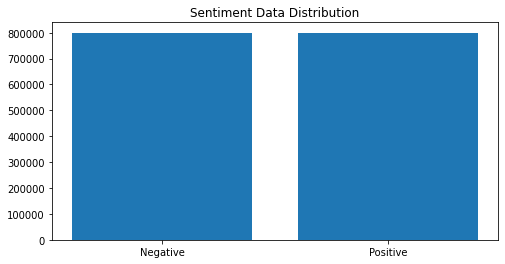

In [8]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

#Text preprocessing

In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [11]:
df.text = df.text.apply(lambda x: preprocess(x))


#Positive words

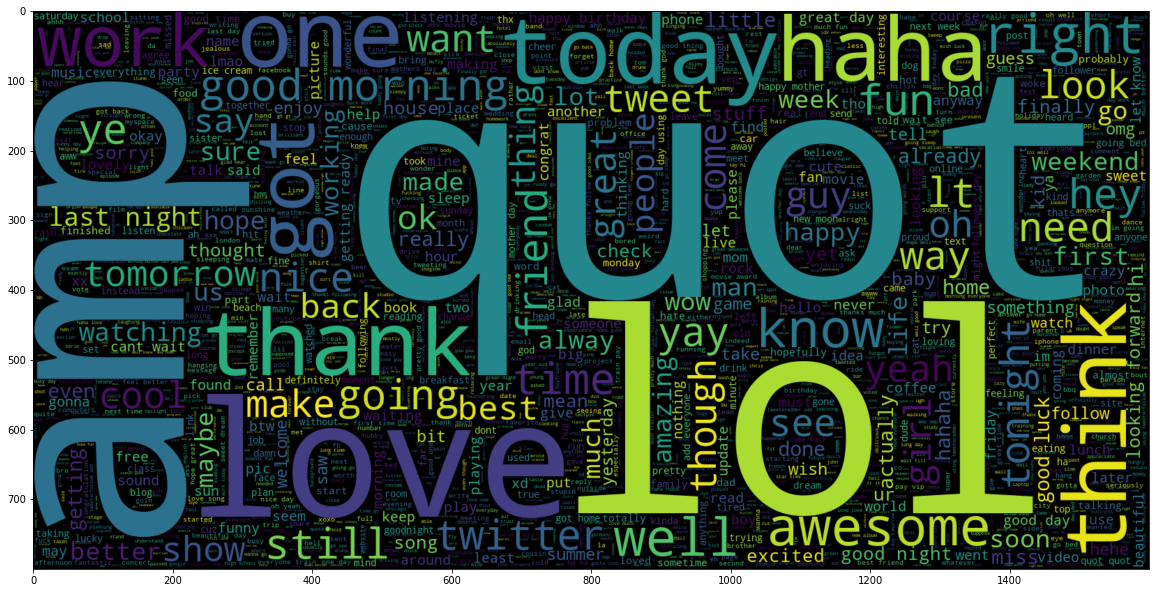

In [12]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

#Negative words

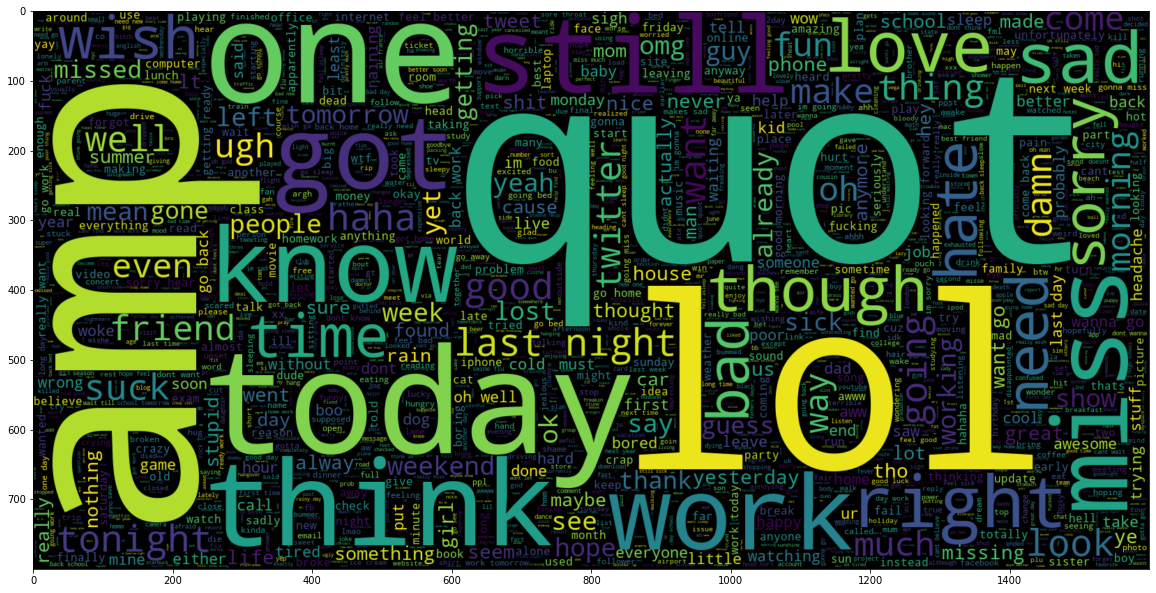

In [13]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

# Train & test split

In [14]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [15]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


# Tokenization

In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [17]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [18]:
labels = train_data.sentiment.unique().tolist()

#Label encoding

In [19]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


#Word embedding

In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-10-04 14:29:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-10-04 14:29:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-04 14:29:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [21]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [22]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [23]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [24]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model Training LSTM

In [25]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [28]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [29]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 269s 187ms/step - loss: 0.5199 - accuracy: 0.7389 - val_loss: 0.4882 - val_accuracy: 0.7627
Epoch 2/10
1250/1250 [==============================] - 232s 185ms/step - loss: 0.4877 - accuracy: 0.7625 - val_loss: 0.4707 - val_accuracy: 0.7736
Epoch 3/10
1250/1250 [==============================] - 230s 184ms/step - loss: 0.4772 - accuracy: 0.7692 - val_loss: 0.4656 - val_accuracy: 0.7767
Epoch 4/10
1250/1250 [==============================] - 233s 187ms/step - loss: 0.4706 - accuracy: 0.7734 - val_loss: 0.4632 - val_accuracy: 0.7781
Epoch 5/10
1250/1250 [==============================] - 232s 186ms/step - loss: 0.4664 - accuracy: 0.7760 - val_loss: 0.4620 - val_accuracy: 0.7789
Epoch 6/10
1250/1250 [==============================] - 234s 187ms/step - loss: 0.4629 - accuracy: 0.7779 - val_loss: 0.4615 - val_accuracy: 0.7800
Epoch 7/10
1250/1250 [==============================] - 233s 187ms/step - loss: 0.4604 - accuracy: 0.7798 - val_

#Model Evaluation

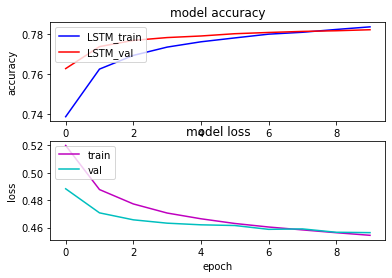

In [30]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [31]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 6s 131ms/step


In [32]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

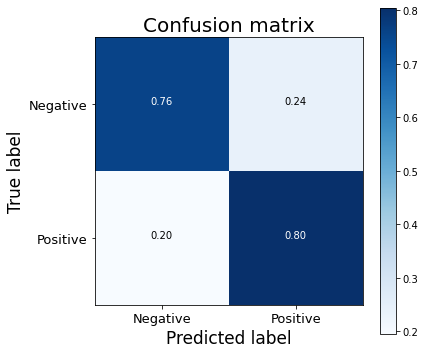

In [33]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

# classification scores

In [34]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.80      0.76      0.78    160542
    Positive       0.77      0.80      0.79    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

